## Data we definitely want to include:
### Outdoor polygons: OSM parks and pitches (indoor = No), Parkserve local parks and recreation.
* We selected five random cities to get
1. Bellingham, Washington — ~93,000
2. Sandpoint, Idaho — ~9,000
3. Ithaca, New York — ~32,000
4. Santa Cruz, California — ~63,000
5. Cedar Rapids, Iowa — ~138,000

In [54]:
import os
import requests
import geopandas as gpd
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import osmnx as ox
from shapely.geometry import shape


# --- CONFIG ---
PLACE_BASE_URL = "https://www2.census.gov/geo/tiger/TIGER2025/PLACE/tl_2025_{statefp}_place.zip"
CACHE_DIR = "cache/place"
os.makedirs(CACHE_DIR, exist_ok=True)

STATE_FIPS = {
    "01": "Alabama", "02": "Alaska", "04": "Arizona", "05": "Arkansas",
    "06": "California", "08": "Colorado", "09": "Connecticut", "10": "Delaware",
    "12": "Florida", "13": "Georgia", "16": "Idaho", "17": "Illinois",
    "18": "Indiana", "19": "Iowa", "20": "Kansas", "21": "Kentucky",
    "22": "Louisiana", "23": "Maine", "24": "Maryland", "25": "Massachusetts",
    "26": "Michigan", "27": "Minnesota", "28": "Mississippi", "29": "Missouri",
    "30": "Montana", "31": "Nebraska", "32": "Nevada", "33": "New Hampshire",
    "34": "New Jersey", "35": "New Mexico", "36": "New York", "37": "North Carolina",
    "38": "North Dakota", "39": "Ohio", "40": "Oklahoma", "41": "Oregon",
    "42": "Pennsylvania", "44": "Rhode Island", "45": "South Carolina",
    "46": "South Dakota", "47": "Tennessee", "48": "Texas", "49": "Utah",
    "50": "Vermont", "51": "Virginia", "53": "Washington", "54": "West Virginia",
    "55": "Wisconsin", "56": "Wyoming"
}

def load_state_places(statefp):
    """Load (or download + cache) a state's PLACE shapefile as GeoDataFrame."""
    zip_path = os.path.join(CACHE_DIR, f"tl_2025_{statefp}_place.zip")

    # Download if not already cached
    if not os.path.exists(zip_path):
        url = PLACE_BASE_URL.format(statefp=statefp)
        print(f"Downloading {STATE_FIPS[statefp]} PLACE file...")
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        with open(zip_path, "wb") as f:
            f.write(r.content)
    else:
        print(f"Using cached file for {STATE_FIPS[statefp]}")

    # Load from local zip
    return gpd.read_file(f"zip://{zip_path}")

 
def get_city_boundary(city_name, state):
    """
    Find and return the boundary GeoDataFrame for a given city within a known U.S. state.
    `state` can be the full state name (e.g., "Colorado") or FIPS (e.g., "08").
    """
    city_name = city_name.lower()

    # Resolve statefp from either state name or FIPS code
    state_lookup = {v.lower(): k for k, v in STATE_FIPS.items()}
    if state.isdigit():
        statefp = state.zfill(2)
        state_name = STATE_FIPS.get(statefp, f"FIPS {statefp}")
    else:
        statefp = state_lookup.get(state.lower())
        if not statefp:
            raise ValueError(f"Unknown state: {state}")
        state_name = state.title()

    # Load the state’s PLACE shapefile (cached if available)
    gdf = load_state_places(statefp)

    # Case-insensitive match for city name
    city_rows = gdf[gdf["NAME"].str.lower() == city_name]

    if city_rows.empty:
        raise ValueError(f"City '{city_name.title()}' not found in {state_name}.")

    city_rows = city_rows.copy()
    city_rows["state_name"] = state_name
    return city_rows

def load_trails(city, state):
    import numpy as np

    boundary_gdf = get_city_boundary(city, state)
    boundary = boundary_gdf.geometry.iloc[0]

    # Step 1 — Broad pull of candidate hiking trails
    tags = {
        "highway": ["path"],      # path only, not footway or track
    }

    trails = ox.features_from_polygon(boundary, tags=tags)
    print("Raw path features:", len(trails))

    # Clean null geometries
    trails = trails[trails.geometry.notnull()].copy()

    # Convert polygons → boundary lines
    trails["geometry"] = trails["geometry"].apply(
        lambda g: g.boundary if g.geom_type in ["Polygon", "MultiPolygon"] else g
    )

    # Keep linework
    trails = trails[trails.geometry.type.isin(["LineString", "MultiLineString"])]
    print("Line geometries:", len(trails))

    # Step 2 — Natural-surface hiking filter
    natural_surfaces = {
        "dirt", "ground", "earth", "grass", "gravel", "fine_gravel",
        "woodchips", "mud", "rock", "sand", "compacted", "unpaved"
    }

    def is_natural_surface(val):
        if isinstance(val, list):
            val = val[0]
        if val is None:
            return False
        return str(val).lower() in natural_surfaces

    # surfaces allowed OR missing if other hiking cues exist
    surface_mask = trails["surface"].apply(is_natural_surface) | trails["surface"].isna()

    # Step 3 — Exclude paved / urban paths explicitly
    paved_surfaces = {"asphalt", "concrete", "paved", "cement", "paving_stones"}

    def is_paved(val):
        if isinstance(val, list):
            val = val[0]
        if val is None:
            return False
        return str(val).lower() in paved_surfaces

    paved_mask = trails["surface"].apply(is_paved)

    # Step 4 — foot allowed OR unspecified  
    foot_mask = trails["foot"].isin(["yes", "designated"]) | trails["foot"].isna()

    # Step 5 — bicycle not allowed  
    bike_mask = trails["bicycle"].isin(["no"]) | trails["bicycle"].isna()

    # Step 6 — bonus “hiking-specific” tags
    hiking_cues = (trails["sac_scale"].notnull()) | (trails["trail_visibility"].notnull())

    # Final mask: must be natural-surface AND foot allowed AND not paved
    final_mask = (
        surface_mask &
        (~paved_mask) &
        bike_mask &
        foot_mask
    ) | hiking_cues

    trails = trails[final_mask].copy()
    print("Filtered hiking trails:", len(trails))

    # Step 7 — Add trail classification
    def classify(row):
        if pd.notnull(row.get("sac_scale")):
            return row["sac_scale"]               # true hiking scale
        if is_natural_surface(row.get("surface")):
            return "natural_surface"
        if row.get("foot") in ["yes", "designated"]:
            return "foot_designated"
        return "hiking_trail"

    trails["trail_type"] = trails.apply(classify, axis=1)

    # Step 8 — Clip to city boundary
    if trails.crs != boundary_gdf.crs:
        trails = trails.to_crs(boundary_gdf.crs)

    trails = gpd.clip(trails, boundary).reset_index(drop=True)

    return trails





### Pull OSM data

In [55]:
# Get OSM data
tags = {
    "leisure": ["park", "pitch", "sports_centre"]
}
def load_osm(city, state):
    city_geom = get_city_boundary(city, state).geometry.iloc[0]
    
    # Download OSM features that *intersect* the city boundary
    gdf_osm = ox.features_from_polygon(city_geom, tags=tags)
    
    # Ensure correct CRS
    gdf_osm = gdf_osm.to_crs("EPSG:4326")

    gdf_osm = gdf_osm[gdf_osm.geometry.type.isin(["Polygon", "MultiPolygon"])]
    # Clip to city boundary (this is the key step!)
    gdf_osm_clipped = gdf_osm.clip(city_geom)
    #only get polygons
    return gdf_osm_clipped

### Pull ParkServe data

In [56]:
import requests
import geopandas as gpd
from shapely.geometry import shape
import json

PARKSERVE_URL = (
    "https://server7.tplgis.org/arcgis7/rest/services/"
    "ParkServe/ParkServe_ProdNew/MapServer/2/query"
)
equal_area_crs = "EPSG:5070"  # US Albers Equal Area — ideal for area in meters²


def get_city_parks_parkserve(city_name, state_name, min_acres=0.1):
    """
    Fetch ParkServe parks that intersect a SINGLE city and return in EPSG:4326.
    
    Args:
        city_name (str): Name of the city (case-insensitive)
        state_name (str): Full state name (e.g., "Washington") or FIPS code
        min_acres (float): Minimum park size in acres to keep

    Returns:
        GeoDataFrame (EPSG:4326) ready for Folium plotting
    """
    # --- 1. Get city boundary ---
    city_row = get_city_boundary(city_name, state_name).iloc[0]  # Use your existing function
    city_geom = city_row.geometry
    city_name = city_row["NAME"]

    # Build bounding envelope for ArcGIS query
    bounds = city_geom.bounds
    envelope = {
        "xmin": bounds[0],
        "ymin": bounds[1],
        "xmax": bounds[2],
        "ymax": bounds[3],
        "spatialReference": {"wkid": 4326}
    }

    # --- 2. Fetch ParkServe features ---
    features = []
    offset = 0
    while True:
        params = {
            "where": "(park_designation = 'LP' OR park_designation = 'LREC')",
            "outFields": "*",
            "f": "geojson",
            "geometry": json.dumps(envelope),
            "geometryType": "esriGeometryEnvelope",
            "spatialRel": "esriSpatialRelIntersects",
            "resultOffset": offset,
            "resultRecordCount": 1000,
            "returnGeometry": "true",
            "outSR": 5070,  # original CRS in meters
        }
        r = requests.get(PARKSERVE_URL, params=params, timeout=60)
        r.raise_for_status()
        page = r.json().get("features", [])
        if not page: break
        features.extend(page)
        if len(page) < 1000: break
        offset += 1000

    if not features:
        print(f"No parks found for {city_name}")
        return gpd.GeoDataFrame(columns=["park_name","park_designation","geometry"], crs="EPSG:4326")

    # --- 3. Convert features to GeoDataFrame ---
    parks = gpd.GeoDataFrame(
        [f.get("attributes") or f.get("properties") for f in features if f.get("geometry")],
        geometry=[shape(f["geometry"]) for f in features if f.get("geometry")],
        crs="EPSG:5070"  # original CRS from ParkServe
    )

    # Fix invalid geometries
    parks["geometry"] = parks.geometry.buffer(0)
    parks = parks[~parks.geometry.is_empty]
    # --- 4. Clip parks to city boundary ---
    parks = parks.to_crs("EPSG:4326")
    city_gdf = gpd.GeoDataFrame(geometry=[city_geom.buffer(0)], crs="EPSG:4326")
    parks_clipped = gpd.overlay(parks, city_gdf, how="intersection")
    
    # --- 5. Filter by minimum size ---
    parks_clipped = parks_clipped.to_crs(equal_area_crs)
    parks_clipped["area_acres"] = parks_clipped.geometry.area / 4046.86
    parks_clipped = parks_clipped[parks_clipped["area_acres"] >= min_acres]
    parks_clipped = parks_clipped.to_crs("EPSG:4326")  # ready for Folium


    # --- 6. Reproject to EPSG:4326 for Folium ---
    parks_clipped = parks_clipped.to_crs("EPSG:4326")

    print(f"{city_name}: {len(parks)} parks before clip, {len(parks_clipped)} after clip")
    return parks_clipped


## Visualize data
- To Do: decide wheteher to filter data by minimum size. Some OSM/ParkServe data is very small, and likely not an intential stop. However, it would have a low impact on the final results and we would not have to justify our size cutoff if we left it in.

- #### To run, just change the city and state variables

In [57]:
import folium
import geopandas as gpd
from shapely.geometry import Polygon

city = 'Missoula'
state = 'Montana'

city_geom = get_city_boundary(city,state)
center = city_geom.geometry.iloc[0].centroid
center = [center.y, center.x]  

m = folium.Map(location=center, zoom_start=11, tiles="cartodbpositron")

# Add ParkServe polygons (green)
gdf = get_city_parks_parkserve(city, state)
folium.GeoJson(
    gdf,
    name="ParkServe",
    style_function=lambda x: {"color": "green", "weight": 1, "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(fields=["ParkName"] if "ParkName" in gdf.columns else [])
).add_to(m)

# Add OSM polygons (gray)
gdf_osm = load_osm(city, state)
folium.GeoJson(
    gdf_osm,
    name="OSM Parks",
    style_function=lambda x: {"color": "gray", "weight": 1, "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(fields=["osm_category"] if "osm_category" in gdf_osm.columns else [])
).add_to(m)

# Add OSM trails (orange lines)
gdf_trails = load_trails(city, state)

folium.GeoJson(
    gdf_trails,
    name="Trails",
    style_function=lambda x: {"color": "orange", "weight": 2, "opacity": 0.9},
    tooltip=folium.GeoJsonTooltip(
        fields=["trail_type"] if "trail_type" in gdf_trails.columns else []
    )
).add_to(m)

m.save(f"{city}_park_overlap.html")
m

Using cached file for Montana
Using cached file for Montana
Missoula: 87 parks before clip, 76 after clip
Using cached file for Montana
Using cached file for Montana
Raw path features: 835
Line geometries: 835
Filtered hiking trails: 650


In [ ]:
gdf

### Indoor polygons: OSM sports halls, fitness centres. 

- Average square footage of a fitness studio: https://member.afsfitness.com/content/fitness-studio-fact-sheet
- 3,813 ft. --> 61*61 ft

In [18]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

def load_osm_indoor(city, state):
    """
    Fetch OSM gyms and create ≤61×61 ft indoor zones within building footprints
    for point-only gyms, clipped by other business footprints.
    """
    # --- 1. Get city boundary ---
    
    city_geom = get_city_boundary(city, state)
    if city_geom.crs is None or city_geom.crs.to_epsg() != 4326:
        city_geom = city_geom.to_crs("EPSG:4326")
    city_geom = city_geom.geometry.iloc[0]

    # --- 2. Define OSM tags ---
    gym_tags = {"leisure": ["fitness_centre", "sports_hall"]}
    bldg_tags = {"building": True}
    business_tags = {
        "amenity": True, "shop": True, "office": True,
        "craft": True, "tourism": True, "leisure": True
    }

    # --- 3. Download all OSM features ---
    gdf_gym = ox.features_from_polygon(city_geom, tags=gym_tags)
    gdf_bldgs = ox.features_from_polygon(city_geom, tags=bldg_tags)
    gdf_biz = ox.features_from_polygon(city_geom, tags=business_tags)

    # --- 4. Separate gyms ---
    gdf_gym_points = gdf_gym[gdf_gym.geometry.geom_type == "Point"].copy()
    gdf_gym_polys = gdf_gym[gdf_gym.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()

    # --- 5. Project everything once (for meter units) ---
    crs_m = "EPSG:3857"
    gdf_gym_points = gdf_gym_points.to_crs(crs_m)
    gdf_gym_polys = gdf_gym_polys.to_crs(crs_m)
    gdf_bldgs = gdf_bldgs.to_crs(crs_m)
    gdf_biz = gdf_biz.to_crs(crs_m)

    gdf_bldgs = gdf_bldgs.reset_index(drop=True)

    # --- 6. Spatial joins: assign buildings ---
    gyms_in_bldg = gpd.sjoin(
    gdf_gym_points,   # <— no column filtering
    gdf_bldgs[["geometry"]],
    how="inner",
    predicate="within"
)
    gyms_in_bldg.rename(columns={"index_right": "building_id"}, inplace=True)

    biz_in_bldg = gpd.sjoin(gdf_biz, gdf_bldgs[["geometry"]], how="inner", predicate="within")

    # Handle dynamic naming of the building index column
    join_col = None
    for col in biz_in_bldg.columns:
        if col.startswith("index_") or col.endswith("_right"):
            join_col = col
            break
    
    if join_col is None:
        raise KeyError("Could not find building index column in business join result")
    
    # Group businesses by building ID
    biz_in_bldg.rename(columns={join_col: "building_id"}, inplace=True)
    biz_grouped = biz_in_bldg.groupby("building_id")

    # --- 7. Create indoor zones for point-based gyms ---
    zones = []
    side_ft = 150
    side_m = side_ft * .3048
    half = side_m / 2
    
    for idx, row in gyms_in_bldg.iterrows():
        pt = row.geometry
        bldg_geom = gdf_bldgs.loc[row["building_id"]].geometry
    
        # Create 61x61 ft square, clipped to building
        x, y = pt.x, pt.y
        square = box(x - half, y - half, x + half, y + half)
        zone = square.intersection(bldg_geom)
    
        # Clip by nearby businesses in same building
        if row["building_id"] in biz_grouped.groups:
            biz_points = biz_grouped.get_group(row["building_id"]).geometry
            if not biz_points.empty:
                min_dist = biz_points.distance(pt).min()
                if pd.notna(min_dist) and min_dist > 0:
                    half_dist = min(min_dist / 2.0, half)
                    zone = zone.intersection(pt.buffer(half_dist)).intersection(bldg_geom)
    
        # Preserve attributes from the original point
        zones.append({
            "geometry": zone,
            "gym_name": row.get("name", None),
            "leisure": row.get("leisure", None),
            "amenity": row.get("amenity", None),
            "building_id": row["building_id"]
        })
    
    gdf_zones = gpd.GeoDataFrame(zones, crs=crs_m)


    # --- 8. Combine with polygon gyms (already defined interiors) ---
    all_gyms = pd.concat([gdf_zones, gdf_gym_polys], ignore_index=True)
    all_gyms = all_gyms.set_crs(crs_m, allow_override=True).to_crs("EPSG:4326")

    # --- 9. Clip to city boundary ---
    all_gyms = all_gyms.clip(city_geom)

    return all_gyms


### To Run, just change the city and state variables

In [19]:
city = 'Bellingham'
state = 'Washington'

city_geom = get_city_boundary(city,state)
center = city_geom.geometry.iloc[0].centroid
center = [center.y, center.x]  

m = folium.Map(location=center, zoom_start=11, tiles="cartodbpositron")

# Add OSM polygons (gray)
gdf_osm = load_osm_indoor(city, state)
folium.GeoJson(
    gdf_osm,
    name="OSM Parks",
    style_function=lambda x: {"color": "red", "weight": 1, "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(fields=[c for c in ["gym_name", "leisure","osm_category"] if c in gdf_osm.columns])
).add_to(m)

# Add layer control (toggle layers)
folium.LayerControl().add_to(m)

m.save(f"{city}_indoor.html")
m

Using cached file for Washington
Using cached file for Washington


## Possible Additions: 

Trailheads and indoor play areas

Suggestion: Do not include. There are only 2,000 tagged indoor play areas in the entire world, and over 35,000 places in the US. It is not a large amount of data points to include, especially with the likely small area and focus on children (who don't typically carry phones while playing). Hiking is somewhat more feasible, however, they would need to be grabbed by county instead of city, and they are unevently distributed compared to trails. Moreover, the number of trails in the county depends a lot more on geography compared to city level parks.

In [222]:
# Get OSM data
# --- 2. Define OSM tags ---
recreation_tags = {
    "leisure": [
        "indoor_play",
        "trailhead"
    ],
    "information": ["trailhead"],
    "highway": ["trailhead"]
}

def load_osm_uncertain(city, state):
    city_geom = get_city_boundary(city, state).geometry.iloc[0]
    
    # Download OSM features that *intersect* the city boundary
    gdf_osm = ox.features_from(city+","+state, tags=recreation_tags)
    
    # Ensure correct CRS
    gdf_osm = gdf_osm.to_crs("EPSG:4326")
    #gdf_osm = gdf_osm[gdf_osm.geometry.type.isin(["Polygon", "MultiPolygon"])]
    # Clip to city boundary (this is the key step!)
    #gdf_osm_clipped = gdf_osm.clip(city_geom)
    #only get polygons
    return gdf_osm

In [233]:
city = 'Linn County'
state = 'Iowa'

city_geom = get_city_boundary('Cedar Rapids', 'Iowa')
center = city_geom.geometry.iloc[0].centroid
center = [center.y, center.x]  

m = folium.Map(location=center, zoom_start=11, tiles="cartodbpositron")

# Add OSM polygons (gray)
gdf_osm = load_osm_uncertain(city, state)
folium.GeoJson(
    gdf_osm,
    name="OSM Parks",
    style_function=lambda x: {"color": "red", "weight": 1, "fillOpacity": 0.1},
    tooltip=folium.GeoJsonTooltip(fields=[c for c in ["name", "leisure", "landuse", "osm_category", "highway", "information"] if c in gdf_osm.columns])
).add_to(m)

# Add layer control (toggle layers)
folium.LayerControl().add_to(m)

m.save(f"{city}_indoor.html")
m

Using cached file for Iowa


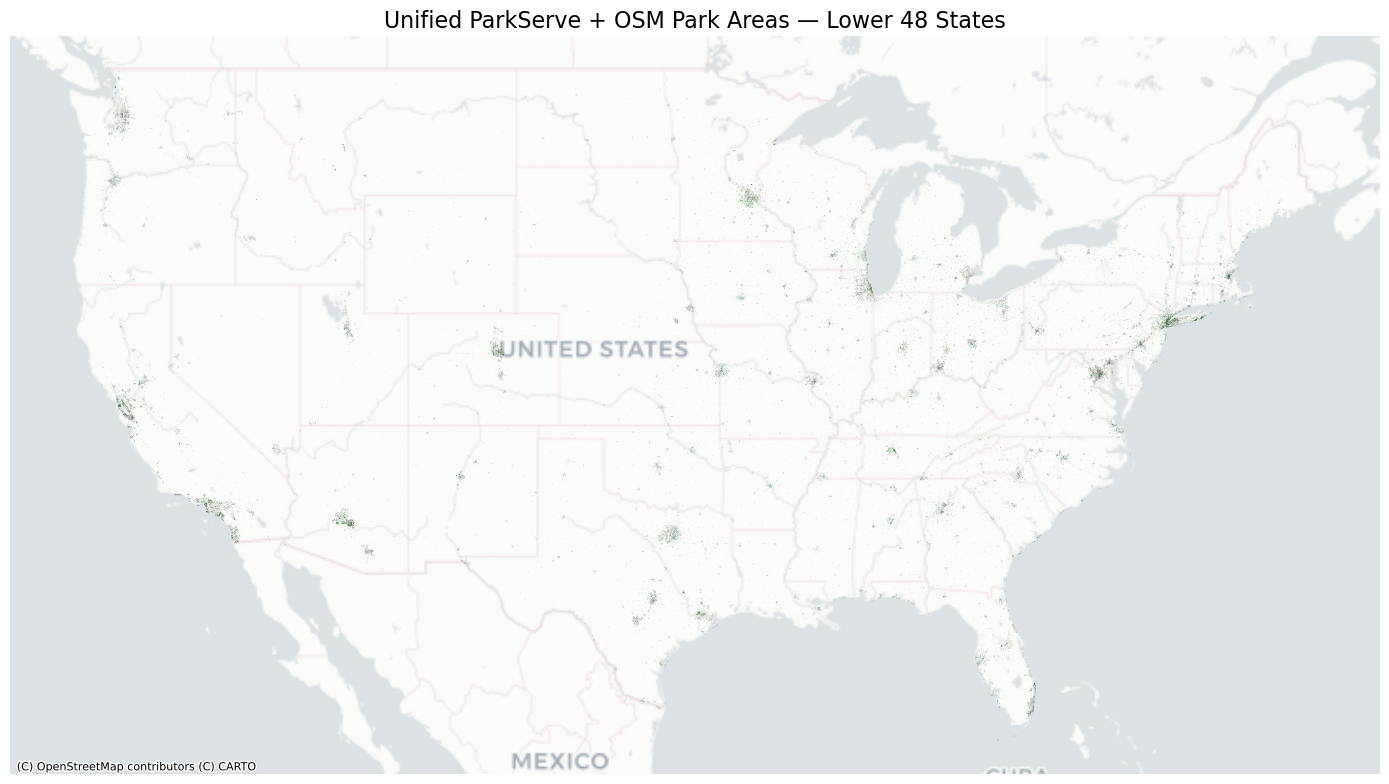

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import glob

# Path to your unified geopackages
gpkg_files = glob.glob("../unified_geopackages_/state_*_unified.gpkg")

# Load all GeoPackages
gdfs = []
for gpkg in gpkg_files:
    try:
        gdf = gpd.read_file(gpkg, layer="unified_park_area")
        gdfs.append(gdf)
    except Exception as e:
        print(f"Failed to load {gpkg}: {e}")

# Combine all into one GeoDataFrame
usa_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Optional: filter to lower 48 (assuming you have a 'state_fips' or 'state_name' column)
# If not, skip this part — it’s only for visualization clarity
exclude_fips = ['02', '15', '72', '78', '66', '69', '60']  # AK, HI, PR, VI, GU, MP, AS
if 'state_fips' in usa_gdf.columns:
    usa_gdf = usa_gdf[~usa_gdf['state_fips'].isin(exclude_fips)]

# Reproject to Web Mercator for basemap
usa_gdf = usa_gdf.to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(14, 10))
usa_gdf.plot(ax=ax, color="forestgreen", alpha=1, linewidth=0)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # or ctx.providers.Stamen.TerrainBackground
    alpha=0.8,
    crs=usa_gdf.crs
)

# Clean up the map
ax.set_title("Unified ParkServe + OSM Park Areas — Lower 48 States", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [6]:
usa_gdf = usa_gdf.to_crs(5070)

In [7]:
usa_gdf["area_m2"] = usa_gdf.geometry.area

In [8]:
print(usa_gdf[["city_name", "area_m2"]].head())
print("Total area:", usa_gdf["area_m2"].sum())

     city_name        area_m2
0     Magnolia  148688.154825
1      Minerva  170615.016110
2   Beach City   20195.872879
3  Blanchester  159548.835466
4  Clarksville            NaN
Total area: 14049169211.74405


In [3]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /Users/tarabrown/Sandbox/osm_fitness/output


In [9]:
usa_gdf.columns

Index(['state_fips', 'placefp', 'city_name', 'area_m2_parks',
       'area_m2_parkserve', 'area_m2_osm', 'date', 'geometry', 'area_m2'],
      dtype='object')

In [11]:
print(usa_gdf.area_m2_parkserve.sum())
print(usa_gdf.area_m2_osm.sum())

9478543927.769373
9458625736.12302


In [13]:
usa_gdf["prop_osm"] = usa_gdf["area_m2_osm"] / usa_gdf["area_m2_parks"]
usa_gdf["prop_ps"] = usa_gdf["area_m2_parkserve"] / usa_gdf["area_m2_parks"]
usa_gdf["osm_vs_ps_ratio"] = usa_gdf["area_m2_osm"] / (usa_gdf["area_m2_parkserve"] + 1e-9)


In [14]:
usa_gdf.replace([float("inf"), -float("inf")], pd.NA, inplace=True)
usa_gdf = usa_gdf.dropna(subset=["osm_vs_ps_ratio"])


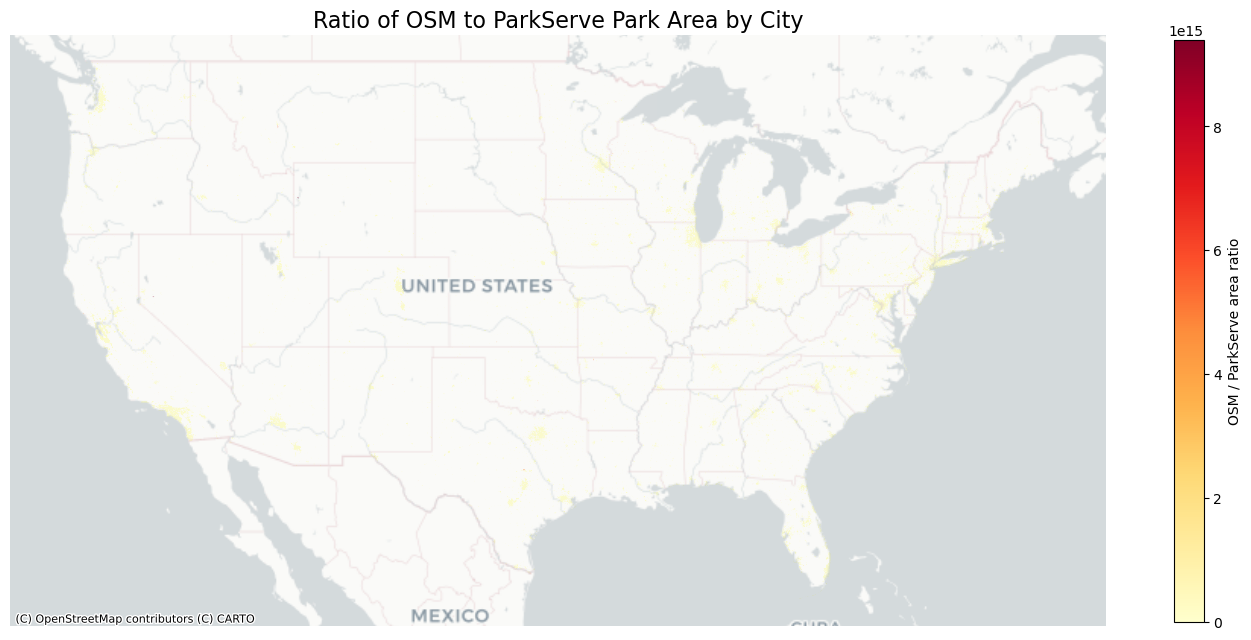

In [15]:
import matplotlib.pyplot as plt
import contextily as ctx

usa_gdf = usa_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(14, 10))

usa_gdf.plot(
    ax=ax,
    column="osm_vs_ps_ratio",
    cmap="YlOrRd",  # red = more OSM-heavy
    legend=True,
    legend_kwds={"label": "OSM / ParkServe area ratio", "shrink": 0.6}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=usa_gdf.crs)
ax.set_axis_off()
ax.set_title("Ratio of OSM to ParkServe Park Area by City", fontsize=16)
plt.tight_layout()
plt.show()


In [20]:
from libpysal.weights import Queen
from esda import Moran
import numpy as np

from libpysal.weights import KNN

w = KNN.from_dataframe(usa_gdf, k=5)
w.transform = "r"

moran = Moran(usa_gdf["prop_osm"], w)

print(f"Moran's I: {mi.I:.4f}")
print(f"p-value: {mi.p_sim:.4f}")


Moran's I: 0.5558
p-value: 0.0010


In [17]:
# Drop missing or invalid geometries
usa_gdf = usa_gdf[~usa_gdf.geometry.is_empty & usa_gdf.geometry.notna()].copy()
usa_gdf = usa_gdf[usa_gdf.geometry.is_valid].copy()

# Optional: ensure polygons only
usa_gdf = usa_gdf[usa_gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()


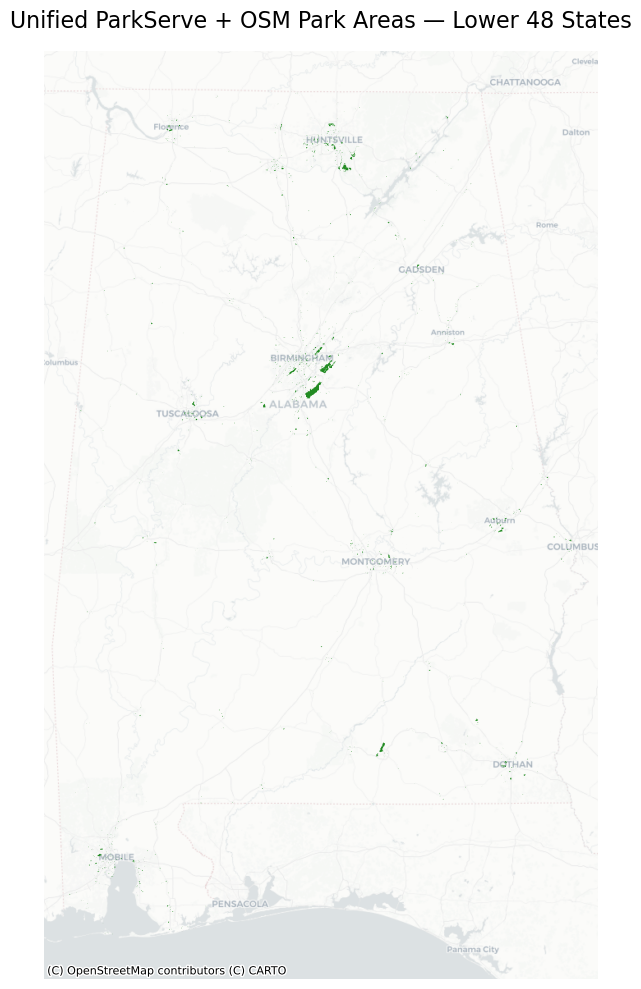

In [4]:
# Path to your unified geopackages
gpkg_files = glob.glob("../unified_geopackages_/state_01_unified.gpkg")

# Load all GeoPackages
gdfs = []
for gpkg in gpkg_files:
    try:
        gdf = gpd.read_file(gpkg, layer="unified_park_area")
        gdfs.append(gdf)
    except Exception as e:
        print(f"Failed to load {gpkg}: {e}")

# Combine all into one GeoDataFrame
usa_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Optional: filter to lower 48 (assuming you have a 'state_fips' or 'state_name' column)
# If not, skip this part — it’s only for visualization clarity
exclude_fips = ['02', '15', '72', '78', '66', '69', '60']  # AK, HI, PR, VI, GU, MP, AS
if 'state_fips' in usa_gdf.columns:
    usa_gdf = usa_gdf[~usa_gdf['state_fips'].isin(exclude_fips)]

# Reproject to Web Mercator for basemap
usa_gdf = usa_gdf.to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(14, 10))
usa_gdf.plot(ax=ax, color="forestgreen", alpha=1, linewidth=0)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # or ctx.providers.Stamen.TerrainBackground
    alpha=0.8,
    crs=usa_gdf.crs
)

# Clean up the map
ax.set_title("Unified ParkServe + OSM Park Areas — Lower 48 States", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()
